In [1]:
from fastai.vision import *
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import tifffile

In [2]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [3]:
path = 'data/eurosat-allbands/'

In [12]:
class TiffList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, fn):
        raw = tifffile.imread(str(fn))
        x = pil2tensor(raw,np.float32)
        return x

In [13]:
data = TiffList.from_folder(path)

In [87]:
def calculate_stats_eurosat_allbands(data):
    all_images = torch.zeros((27000, 13, 64, 64))
    for i, im in enumerate(data):
        all_images[i] = im
    
    stat_mean = all_images.mean(-1).mean(-1).mean(0)
    stat_std = all_images.std(-1).std(-1).std(0)
    
    return (stat_mean.tolist(), stat_std.tolist())

In [6]:
stats_eurosat_allbands = ([1353.73046875,
  1117.2020263671875,
  1041.8876953125,
  946.5513305664062,
  1199.1883544921875,
  2003.0101318359375,
  2374.01171875,
  2301.222412109375,
  732.1828002929688,
  12.099513053894043,
  1820.6893310546875,
  1118.1998291015625,
  2599.784912109375],
 [30.343395233154297,
  66.4549560546875,
  71.52734375,
  86.9700698852539,
  70.47565460205078,
  81.35286712646484,
  97.88168334960938,
  99.96805572509766,
  27.891748428344727,
  0.32882159948349,
  92.60734558105469,
  87.39993286132812,
  106.57888793945312])

In [15]:
data = data.split_by_rand_pct()

In [16]:
data = data.label_from_folder()

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
data = data.transform(tfms, size=64)

In [17]:
data = data.databunch()

In [21]:
data = data.normalize(stats_eurosat_allbands)

Exception: Can not call normalize twice

In [43]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=0, sub=0, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak != 0 else F.relu(x)
        if self.sub != 0: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=1, zero_bn=False, act=True, bias=False, **kwargs):
        super().__init__()
        self.bn = nn.BatchNorm2d(nf)
        nn.init.constant_(self.bn.weight, 0. if zero_bn else 1.)
        self.conv = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)
        if act: 
            self.relu = GeneralRelu(**kwargs)
            
        self.act = act
    
    def forward(self, x): 
        out = (self.bn(self.conv(x)))
        if self.act: out = self.relu(out)
        return out
    
    def has_relu(self):
        return self.act
    
    @property
    def bias(self):
        return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight
    
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def is_monitored_layer(l):
    mon_layers = (nn.Linear, ConvLayer)
    return isinstance(l, mon_layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1, **kwargs):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [ConvLayer(ni, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 3, zero_bn=True, act=False, **kwargs)
        ] if expansion == 1 else [
                   ConvLayer(ni, nh, 1, **kwargs),
                   ConvLayer(nh, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 1, zero_bn=True, act=False, **kwargs)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act=False, **kwargs)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act_fn = GeneralRelu(**kwargs)

    def forward(self, x): 

        return self.act_fn(self.convs(x) + self.idconv(self.pool(x)))
    

class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=10, **kwargs):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [ConvLayer(nfs[i], nfs[i+1], stride=2 if i==0 else 1, **kwargs)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2, **kwargs)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        #init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride, **kwargs):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, **kwargs)
              for i in range(n_blocks)])
    
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)

In [54]:
model = xresnet50(c_in=13, c_out=data.c)

In [55]:

learn = Learner(data, model, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


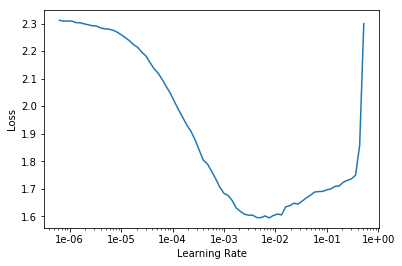

In [56]:
learn.lr_find()
learn.recorder.plot()

In [47]:
lr = 1e-4

learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.768794,0.587075,0.820000,00:21
1,0.389098,0.284478,0.906111,00:21
2,0.268844,0.242878,0.913519,00:21
3,0.230108,0.177486,0.940000,00:21
4,0.176991,0.155455,0.947778,00:21
5,0.151586,0.128312,0.958704,00:21
6,0.128643,0.101526,0.967407,00:21
7,0.081511,0.097560,0.966667,00:21
8,0.071549,0.078774,0.974259,00:21
9,0.055394,0.065412,0.976852,00:21


In [57]:
lr = 1e-3

learn.fit_one_cycle(15, lr)



epoch,train_loss,valid_loss,accuracy,time
0,0.408788,0.346639,0.875926,00:21
1,0.343693,0.273473,0.908148,00:21
2,0.338689,0.352981,0.881667,00:21
3,0.287734,0.198303,0.931481,00:21
4,0.238721,0.187830,0.936481,00:21
5,0.208355,0.177166,0.946852,00:21
6,0.152803,0.200622,0.935000,00:21
7,0.130123,0.115949,0.959630,00:21
8,0.093435,0.120453,0.964259,00:21
9,0.082802,0.072581,0.977222,00:21


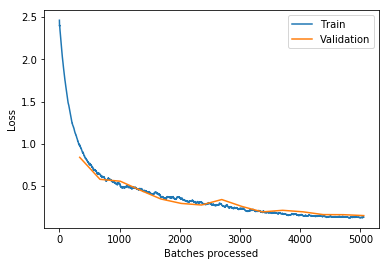

In [16]:
learn.recorder.plot_losses()